In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

plt.rcParams['figure.figsize'] = (8, 8)

/Users/jam3jam/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


credits for baseline data and code:  Marc Harper, GA LA <br>
ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_mm_mlo.txt <br>
http://earthobservatory.nasa.gov/blogs/climateqa/mauna-loa-co2-record/


In [2]:
filename = "ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_mm_mlo.txt"
columns = ["year", "month", "decimal date", "average", "interpolated", "trend", "?"]

co2 = pd.read_csv(filename, delim_whitespace=True, skiprows=72, names=columns)
co2.dropna(inplace=True)
co2.head()

,year,month,decimal date,average,interpolated,trend,?
0,1958,3,1958.208,315.71,315.71,314.62,-1
1,1958,4,1958.292,317.45,317.45,315.29,-1
2,1958,5,1958.375,317.50,317.50,314.71,-1
3,1958,6,1958.458,-99.99,317.10,314.85,-1
4,1958,7,1958.542,315.86,315.86,314.98,-1


In [3]:
def make_date(row):
    year = str(int(row['year']))
    month = str(int(row['month']))
    if len(month) < 2:
        month = '0' + month
    day = '01'
    return "{}-{}-{}".format(year, month, day)

co2['Date'] = co2.apply(make_date, axis=1)
co2['Date'] = pd.to_datetime(co2['Date'], format='%Y-%m-%d')
co2['date'] = co2['Date']
co2.set_index('Date', inplace=True)
co2.head()

,year,month,decimal date,average,interpolated,trend,?,date
Date,,,,,,,,
1958-03-01,1958,3,1958.208,315.71,315.71,314.62,-1,1958-03-01
1958-04-01,1958,4,1958.292,317.45,317.45,315.29,-1,1958-04-01
1958-05-01,1958,5,1958.375,317.50,317.50,314.71,-1,1958-05-01
1958-06-01,1958,6,1958.458,-99.99,317.10,314.85,-1,1958-06-01
1958-07-01,1958,7,1958.542,315.86,315.86,314.98,-1,1958-07-01


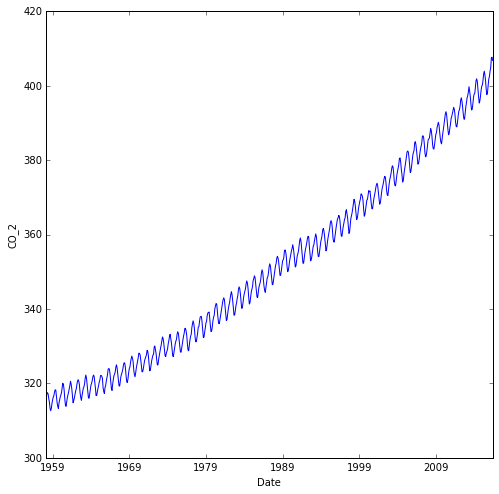

In [4]:
plt.plot(co2.index, co2["interpolated"])
plt.ylabel("CO_2")
plt.xlabel("Date")
plt.show()

## Build DataFrame

In [5]:
df = pd.DataFrame()
df['y'] = co2["interpolated"]
df['x'] = co2["date"].apply(lambda x: x.toordinal())
df['Date'] = co2["date"]
df.set_index('Date', inplace=True)

df.head()

,y,x
Date,,
1958-03-01,315.71,714839
1958-04-01,317.45,714870
1958-05-01,317.50,714900
1958-06-01,317.10,714931
1958-07-01,315.86,714961


## Modeling

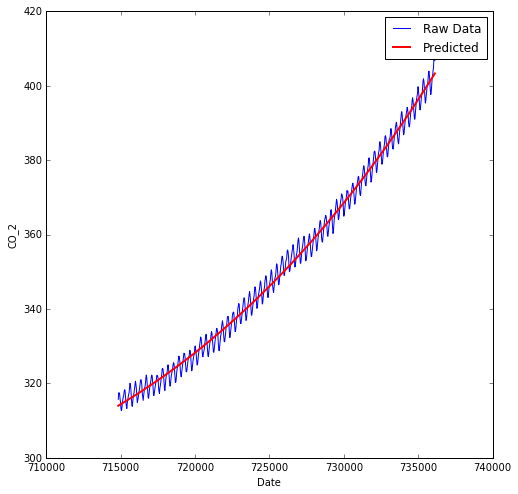

In [6]:
X = np.vander(df['x'], 3)
y = np.log(df['y'])

from sklearn import linear_model

model = linear_model.LinearRegression()

model.fit(X, y)

plt.plot(df['x'], df['y'], label="Raw Data")
plt.plot(df['x'], np.exp(model.predict(X)), label="Predicted", color='r', linewidth='2')
plt.ylabel("CO_2")
plt.xlabel("Date")
plt.legend()

## Subtract off the Predicted Trend

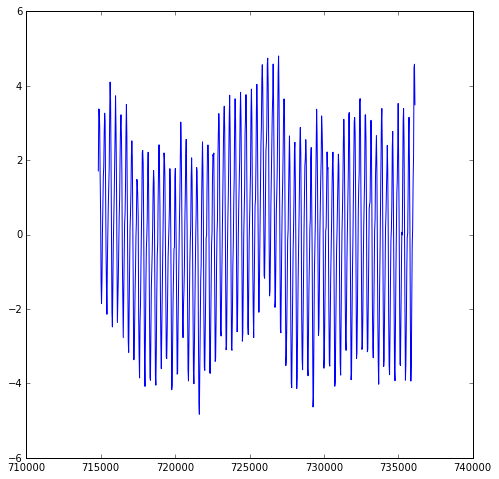

In [7]:
df['y2'] = df['y'] - np.exp(model.predict(X))
plt.plot(df['x'], df['y2'])

## Analyzing the Time Series

### We can use autocorrelation to measure the self-similarity of the time series. In this case we expect a yearly cycle.



In [8]:
# Monthly
df['y2'].autocorr(lag=1)

0.84835446850387686

In [9]:
# Yearly
df['y2'].autocorr(lag=12)

0.96440697611055803

### As you can see there is a very strong yearly autocorrelation, as expected. We can take a look at a range of lag values with a plot from statsmodels.

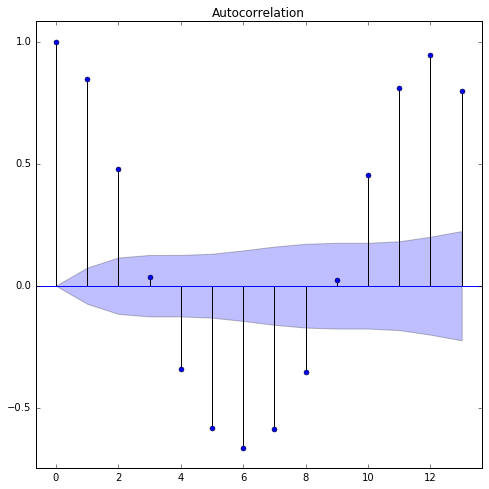

In [10]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df['y2'], lags=13)
plt.show()

## Part 2 (Resumption of Exercise)

## Forecasting with ARMA and ARIMA
We can apply a time series forecasting model via Python's statsmodels.
<a href="https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average">ARMA Model Wikipedia</a>

In [18]:
from statsmodels.tsa.arima_model import ARMA

model = ARMA(df['y2'], (1, 1)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                     y2   No. Observations:                  700
Model:                     ARMA(1, 1)   Log Likelihood                -878.394
Method:                       css-mle   S.D. of innovations              0.847
Date:                Wed, 03 Aug 2016   AIC                           1764.788
Time:                        02:37:03   BIC                           1782.992
Sample:                    03-01-1958   HQIC                          1771.825
                         - 06-01-2016                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0299      0.256      0.117      0.907        -0.471     0.531
ar.L1.y2       0.7885      0.024     33.135      0.000         0.742     0.835
ma.L1.y2       0.6978      0.022     32.192      0.000         0.655     0.740
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2683           +0.0000j            1.2683            0.0000
MA.1           -1.4330           +0.0000j            1.4330            0.5000
-----------------------------------------------------------------------------
"""

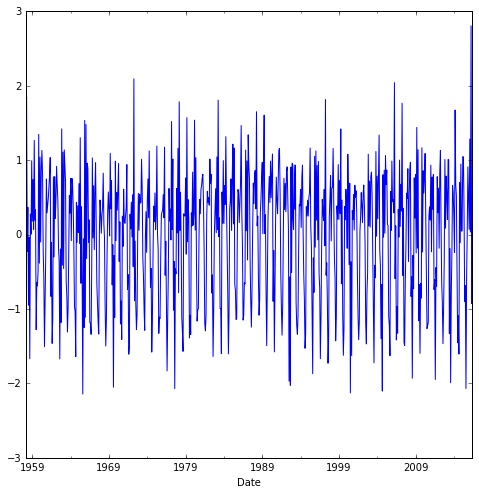

In [19]:
model.resid.plot()

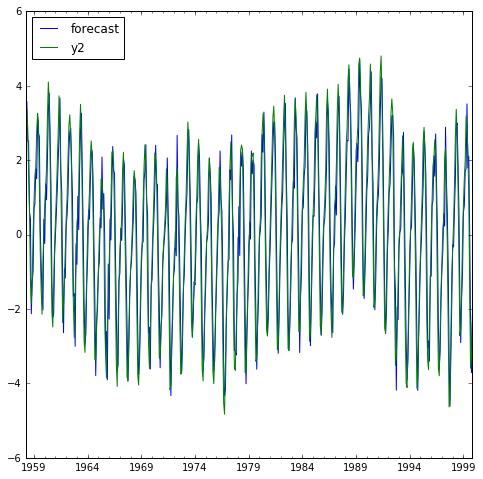

In [20]:
model.plot_predict(1, 500)
plt.show()

We have the option of combining our model for the mean to make predictions--or instead fitting an ARIMA model to the raw data directly.  The latter solution allows the increasing mean to be a part of the model.

In [51]:
from statsmodels.tsa.arima_model import ARIMA

model2 = ARIMA(co2['interpolated'], (1, 1, 2)).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.interpolated   No. Observations:                  699
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -892.818
Method:                       css-mle   S.D. of innovations              0.867
Date:                Wed, 03 Aug 2016   AIC                           1795.637
Time:                        02:46:49   BIC                           1818.385
Sample:                    04-01-1958   HQIC                          1804.431
                         - 06-01-2016                                         
========================================================================================
                           coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
const                    0.1275      0.011     11.639      0.000         0.106     0.149
ar.L1.D.interpolated     0.8119      0.026     30.840      0.000         0.760     0.864
ma.L1.D.interpolated    -0.2691      0.024    -11.312      0.000        -0.316    -0.222
ma.L2.D.interpolated    -0.6701      0.022    -31.094      0.000        -0.712    -0.628
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2317           +0.0000j            1.2317            0.0000
MA.1            1.0372           +0.0000j            1.0372            0.0000
MA.2           -1.4388           +0.0000j            1.4388            0.5000
-----------------------------------------------------------------------------
"""

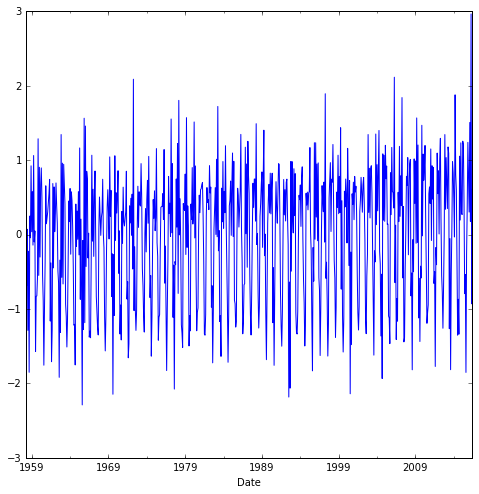

In [52]:
model2.resid.plot()

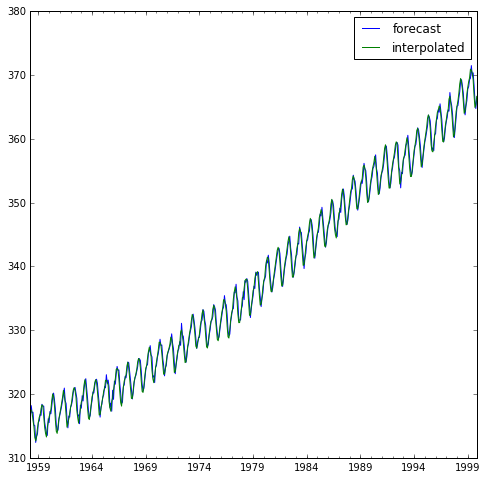

In [53]:
model2.plot_predict(1, 500)
plt.show()

See above--our model matches the raw data rather well.

Finally, predicting the future

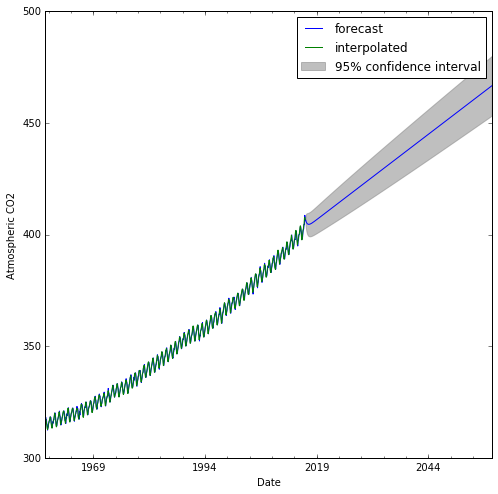

In [54]:
model2.plot_predict(1, 1200)
plt.xlabel("Date")
plt.ylabel("Atmospheric CO2")
plt.show()

In [56]:
!pwd

/Users/jam3jam/dsi/DSI-SM-1/DSI_SM_01/curriculum/week-09/2.2-lesson/code
